# Crude Estimates of Aerodynamic Forces

## <font color="blue">Model</font>
Quasi-Steady model - Decompose the aerodynamic force linearly into the following components:<br>
(1) Translational lift force<br>
(2) Translational drag force<br>
(3) Rotational force<br>
(4) Added mass force<br>

<br>
_(References: Dickinson+[2008](http://arc.aiaa.org/doi/10.2514/1.29862); Chin and Lentink [2016](http://jeb.biologists.org/content/219/7/920))_

## <font color="blue">Assumptions</font>
<br>
_(Note: All the numbers are based on the kinematics (see the kinematic [notebook](https://github.com/Mipanox/ME303/blob/master/kinematics/kinematics.ipynb))_
<br>
* Neglect forces exerted by body, tail, and feet (at the moment)
* Wing is rectangular with aspect ratio of 2
<br><p style="text-indent: 30px">The half-wingspan (i.e. for a single wing) is taken to be $40$cm for both species. Hence the chord length is (uniformly) $20$cm.<br><br>
* Wing motion is sinusoidal with fixed frequency, amplitude, and rotational angle (with $45^\circ$ at midstroke)
<br><p style="text-indent: 30px">1. Avocet: `amplitude` $\approx15$cm; `frequency` $\approx5$Hz $\approx30$rad/s
<br><p style="text-indent: 30px">2. Shoveler: `amplitude` $\approx10$cm; `frequency` $\approx4$Hz $\approx24$rad/s

### <font color="green">Scenarios</font>
Let's focus first on two scenarios during landing:
1. Steady flight with body aligned parallel to the horizontal
<br><p style="text-indent: 30px">$v_\text{body} \approx 1000$cm/s on average
2. Stopping phase where the body (and so do the wings) is $\theta$ degrees tilted w.r.t. the horizontal
<br><p style="text-indent: 30px">$v_\text{body} \approx 500$cm/s on average<br>
<br><p style="text-indent: 30px">$\theta\approx60^\circ$ and $\approx20^\circ$ for Avocet and Shoveler respectively.
<br><p style="text-indent: 30px">(Note: Assuming horizontal wind (or rest) velocity, this is also the angle of attack. Namely $\alpha\sim\theta$

In [2]:
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

Define at time $t=0$, the wing starts a downstroke, with zero rotation

In [4]:
## parameters
### global
#--- 200 time steps
time_elapse = np.linspace(0.,1.,200)
rho_air     = 1. * u.kg/u.m**3

wing_w_avo  = 2*np.pi*5 * u.Hz
wing_w_sho  = 2*np.pi*4 * u.Hz
wing_a_avo  = 15. * u.cm
wing_a_sho  = 10. * u.cm

###- column vectors
#--- 100 strips of wing segments now with equal chord length
wing_r = np.linspace(0.,40.,100).reshape(100,1) * u.cm
wing_c = np.ones(100).reshape(100,1) *20 * u.cm

v_wing_avo = (wing_w_avo * wing_r).to(u.cm/u.s)
v_wing_sho = (wing_w_sho * wing_r).to(u.cm/u.s)

### Scenario 1
v_body_1 = 1000. * u.cm/u.s
alpha_avo_1 = np.rad2deg(np.arctan(v_wing_avo/v_body_1)) + \
              np.sin(wing_w_avo.value*time_elapse)*45*u.deg 
alpha_sho_1 = np.rad2deg(np.arctan(v_wing_sho/v_body_1)) + \
              np.sin(wing_w_sho.value*time_elapse)*45*u.deg

#--- cosine rule
v_tot_avo_1 = np.sqrt(v_body_1**2 + v_wing_avo**2 - \
                      2*v_body_1*v_wing_avo*np.cos(np.deg2rad(alpha_avo_1)))
v_tot_sho_1 = np.sqrt(v_body_1**2 + v_wing_sho**2 - \
                      2*v_body_1*v_wing_sho*np.cos(np.deg2rad(alpha_sho_1)))
    
### Scenario 2
v_body_2 = 500.  * u.cm/u.s
alpha_avo_2 = np.rad2deg(np.arctan(v_wing_avo/v_body_2)) + \
              np.sin(wing_w_avo.value*time_elapse)*45*u.deg + 60*u.deg
alpha_sho_2 = np.rad2deg(np.arctan(v_wing_sho/v_body_2)) + \
              np.sin(wing_w_sho.value*time_elapse)*45*u.deg + 20*u.deg

#--- cosine rule
v_tot_avo_2 = np.sqrt(v_body_2**2 + v_wing_avo**2 - \
                      2*v_body_2*v_wing_avo*np.cos(np.deg2rad(alpha_avo_2)))
v_tot_sho_2 = np.sqrt(v_body_1**2 + v_wing_sho**2 - \
                      2*v_body_2*v_wing_sho*np.cos(np.deg2rad(alpha_sho_2)))

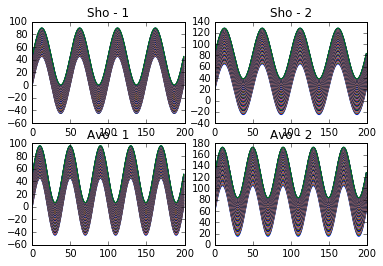

In [11]:
plt.subplot(221)
for i in range(alpha_sho_1.shape[0]):
    plt.plot(alpha_sho_1[i])
    plt.title('Sho - 1')
    
plt.subplot(222)
for i in range(alpha_sho_2.shape[0]):
    plt.plot(alpha_sho_2[i])
    plt.title('Sho - 2')
    
plt.subplot(223)
for i in range(alpha_avo_1.shape[0]):
    plt.plot(alpha_avo_1[i])
    plt.title('Avo - 1')
    
plt.subplot(224)
for i in range(alpha_avo_2.shape[0]):
    plt.plot(alpha_avo_2[i])
    plt.title('Avo - 2')

In [112]:
def lift_drag_coeff(alpha):
    ## initialize
    C_L,C_D = np.zeros(alpha.shape),np.zeros(alpha.shape)
    
    for ((i,j),alp) in np.ndenumerate(alpha):
        if alp >= 0:
            a_L = np.deg2rad(0.0301*alp+4.7124)
            a_D = np.deg2rad(0.0073*alp+3.1416)
            C_L[i,j] = 0.0031 + 1.5842 * np.cos(a_L)
            C_D[i,j] = 8.3171 + 8.1909 * np.cos(a_D)
        else:
            a_L = np.deg2rad(0.0332*alp+4.6963)
            a_D = np.deg2rad(0.0281*alp+1.277)
            C_L[i,j] = 0.0028 + 1.1251 * np.cos(a_L)
            C_D[i,j] = 1.1993 + 1.0938 * np.cos(a_D)
        
    return C_L, C_D

def transl_forces(c,r,v,alpha,rho=rho_air):
    """
    Returns the translational forces at each time stamp
    """
    pref = 0.5*rho*c
    C_L,C_D = lift_drag_coeff(alpha)
    
    F_L = np.trapz(pref*v**2*C_L,r,axis=0).to(u.kg*u.m/u.s**2)
    F_D = np.trapz(pref*v**2*C_D,r,axis=0).to(u.kg*u.m/u.s**2)
    
    return F_L, F_D

### <font color="red">Results</font>

In [124]:
avo_fl_1,avo_fd_1 = transl_forces(wing_c,wing_r,v_tot_avo_1,alpha_avo_1)
avo_fl_2,avo_fd_2 = transl_forces(wing_c,wing_r,v_tot_avo_2,alpha_avo_2)
sho_fl_1,sho_fd_1 = transl_forces(wing_c,wing_r,v_tot_sho_1,alpha_sho_1)
sho_fl_2,sho_fd_2 = transl_forces(wing_c,wing_r,v_tot_sho_2,alpha_sho_2)

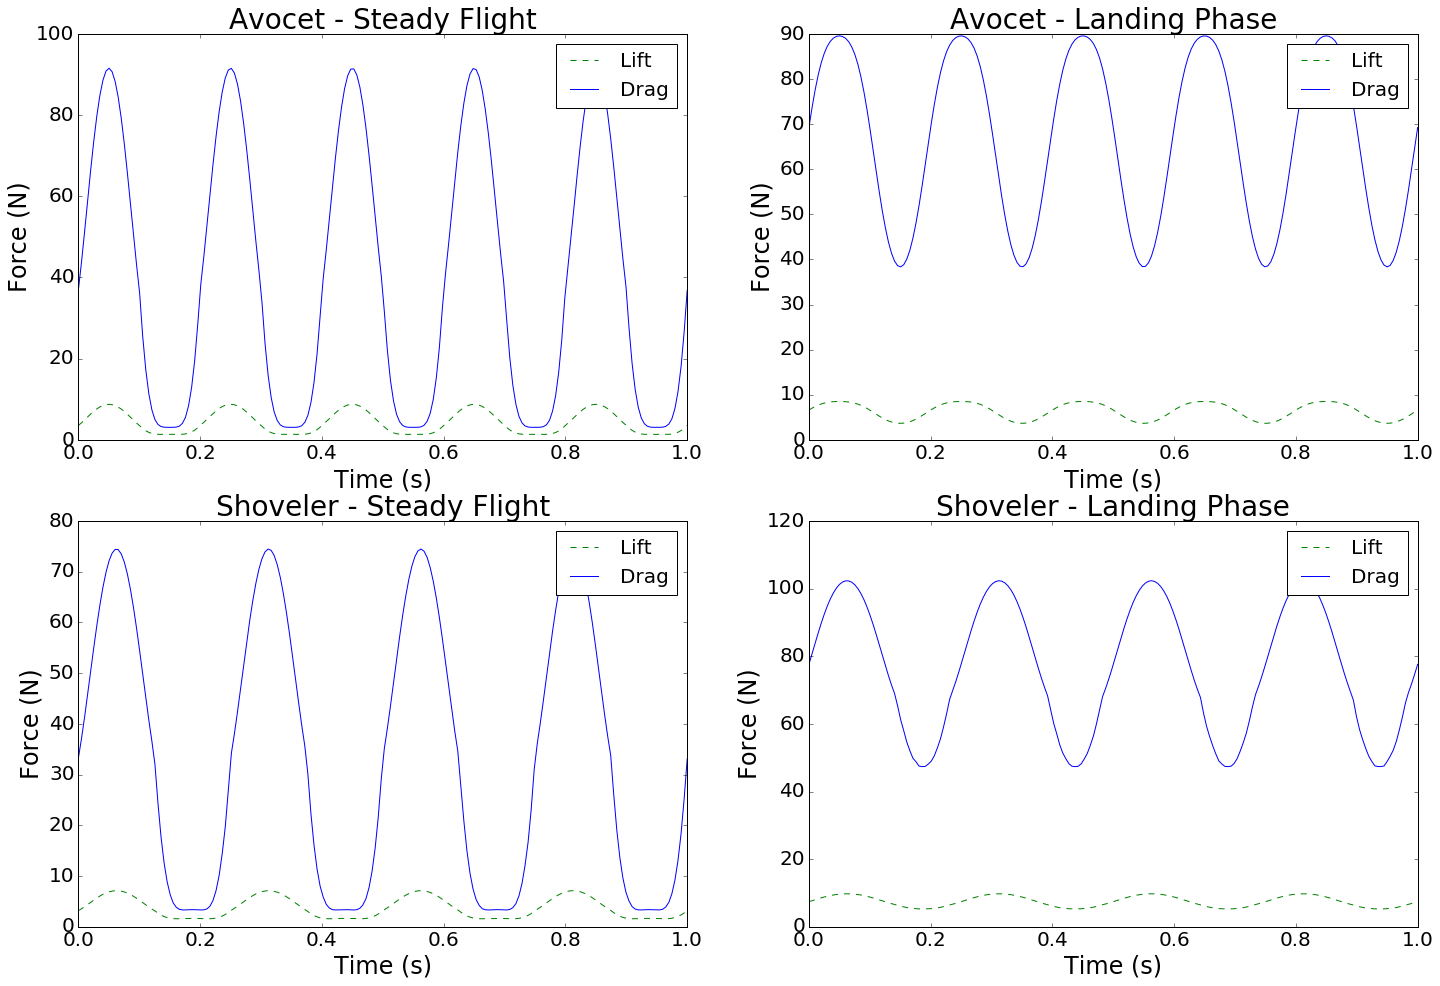

In [125]:
plt.figure(figsize=(24,16))

plt.subplot(221)
plt.plot(time_elapse,avo_fl_1,'g--',label='Lift')
plt.plot(time_elapse,avo_fd_1,'b-',label='Drag')
plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Force (N)',fontsize=24)
plt.xticks(fontsize=20); plt.yticks(fontsize=20); plt.legend(fontsize=20)
plt.title('Avocet - Steady Flight',fontsize=28)
plt.subplot(222)
plt.plot(time_elapse,avo_fl_2,'g--',label='Lift')
plt.plot(time_elapse,avo_fd_2,'b-',label='Drag')
plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Force (N)',fontsize=24)
plt.xticks(fontsize=20); plt.yticks(fontsize=20); plt.legend(fontsize=20)
plt.title('Avocet - Landing Phase',fontsize=28)

plt.subplot(223)
plt.plot(time_elapse,sho_fl_1,'g--',label='Lift')
plt.plot(time_elapse,sho_fd_1,'b-',label='Drag')
plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Force (N)',fontsize=24)
plt.xticks(fontsize=20); plt.yticks(fontsize=20); plt.legend(fontsize=20)
plt.title('Shoveler - Steady Flight',fontsize=28)
plt.subplot(224)
plt.plot(time_elapse,sho_fl_2,'g--',label='Lift')
plt.plot(time_elapse,sho_fd_2,'b-',label='Drag')
plt.xlabel('Time (s)',fontsize=24); plt.ylabel('Force (N)',fontsize=24)
plt.xticks(fontsize=20); plt.yticks(fontsize=20); plt.legend(fontsize=20)
plt.title('Shoveler - Landing Phase',fontsize=28)

---
#### <font color="magenta">ToDo</font>
1. Other forces
2. Lift/Drag to vertical/horizontal forces; to be used for balancing "masses" and so on


## <font color="blue">Comparison with body motion</font>
In the simplest approximation, we can quantify the dynamics of the bird by examining its body motion, in particular the acceleration. Upon comparing this with the estimated total forces above, **extra** forces that are required to match with the measurements can be deduced.